# ASSIGNMENT 4 - QUESTION 1
# Giang Bui - 37306207 - 30/05/2023

This is a Python Notebook for classifying the Breast-Cancer data using caret.
First we install and load the neccessary packages
## Environment

In [1]:
#!pip install imbalanced-learn
#!pip install umap
#!pip install umap-learn

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

from umap import UMAP

import imblearn
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 



## Data
Now we load the data and examine the data information

In [3]:
# read and explore the data from breast-cancer.csv file
data = pd.read_csv("breast-cancer.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Numeric correlation
Now, we explore the correlation between numeric variables using corr() function.

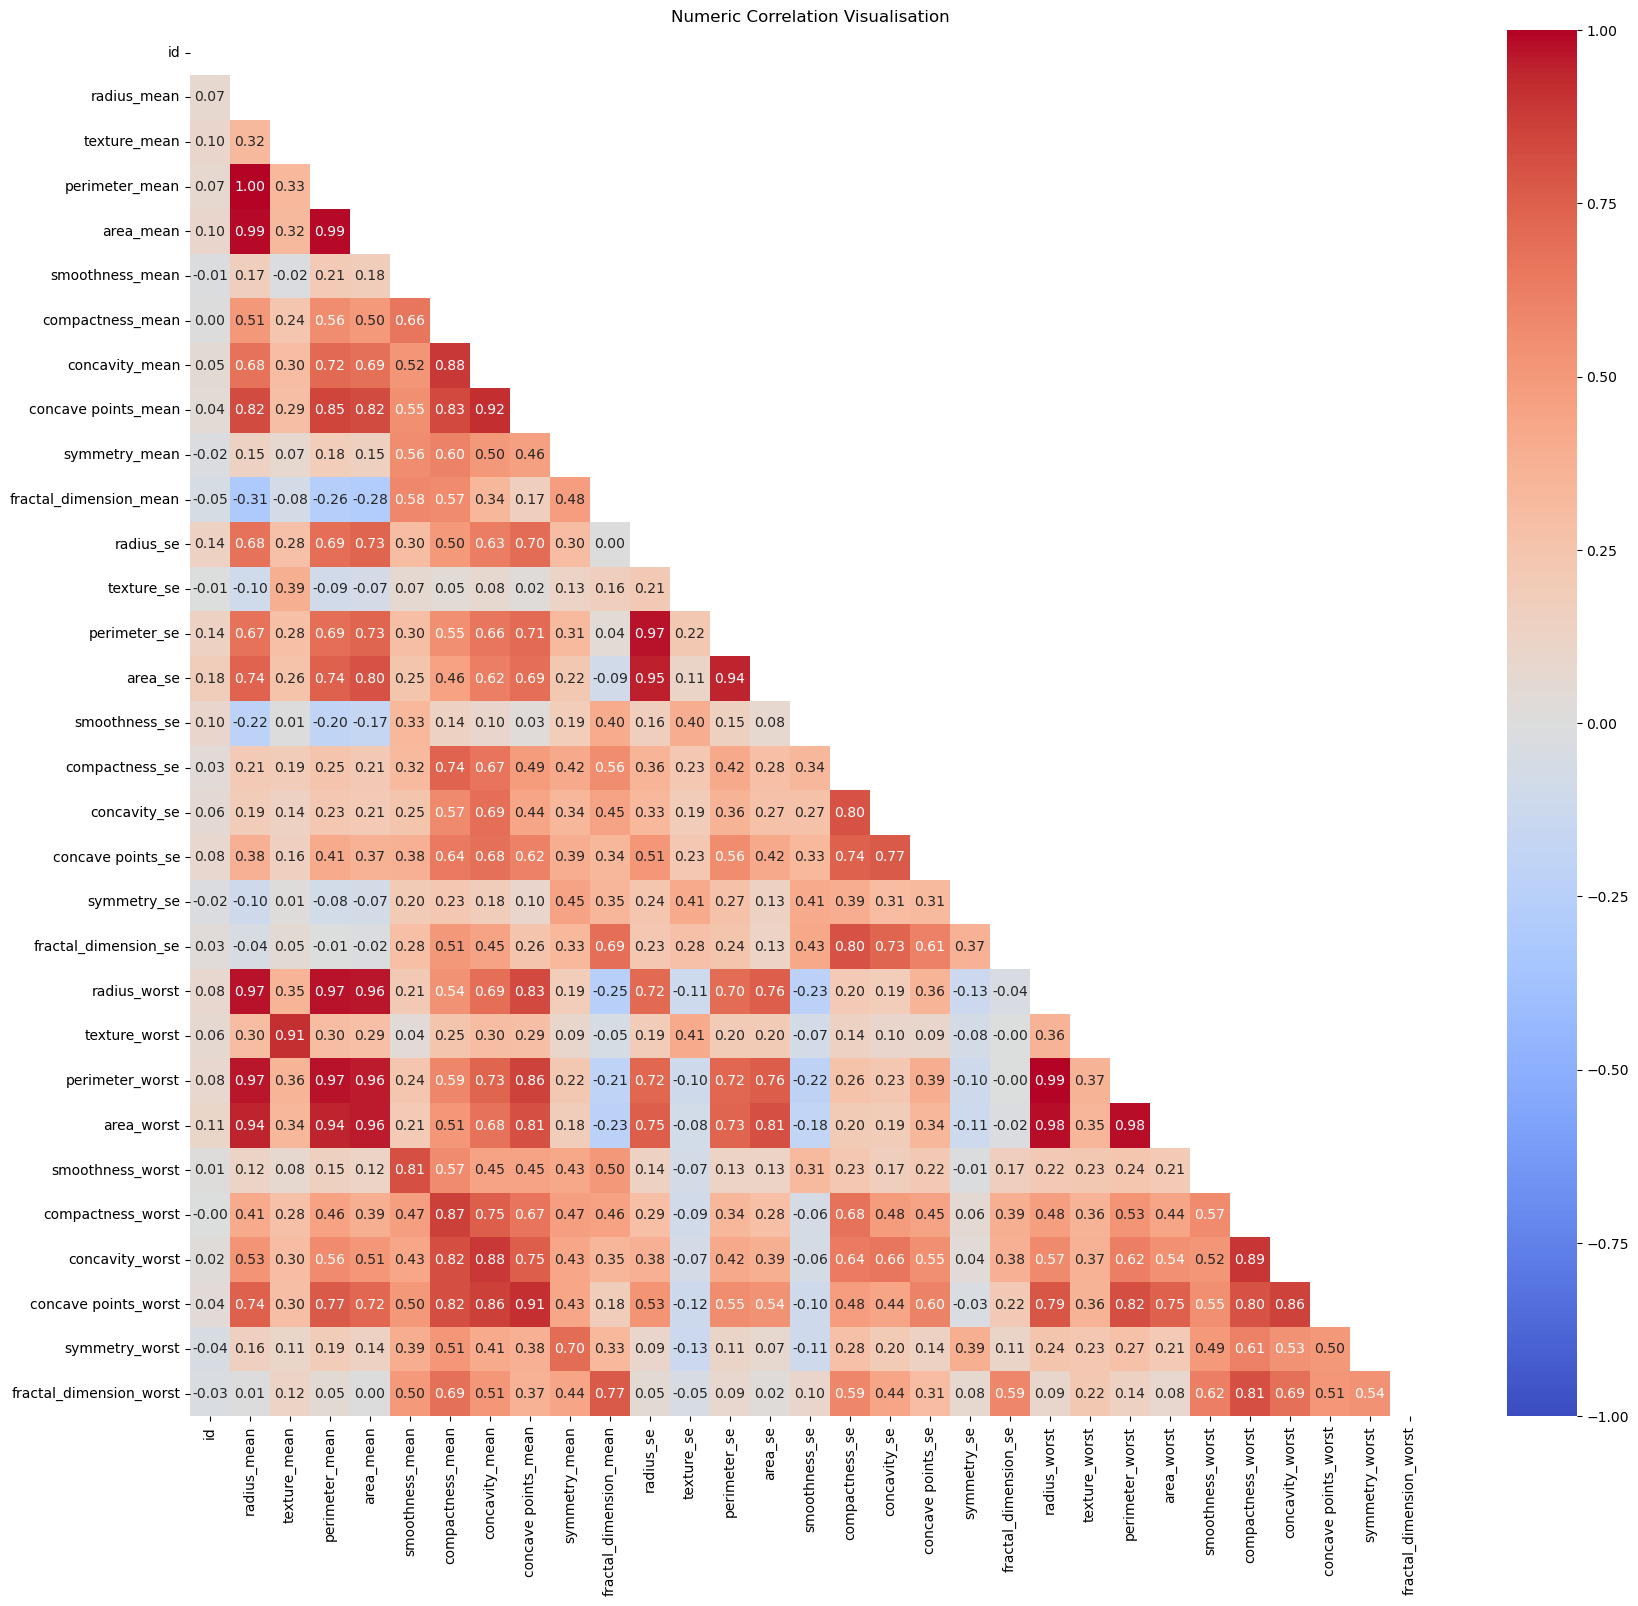

In [4]:
# Calculate correlation matrix
correlation_matrix = data.corr()

# Create a mask array
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Set up the plot
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f", vmin=-1, vmax=1, mask=mask)

# Customize the plot
plt.title('Numeric Correlation Visualisation')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.show()


As we can see there are some strongly high-correlated pairs as the correlation plot above.

## Check class balance of the target variables 'Diagnosis'
Based on the result below, the target variable exhibits class imbalance, with approximately 62.7% of the observations labeled as "B" and 37.3% labeled as "M".



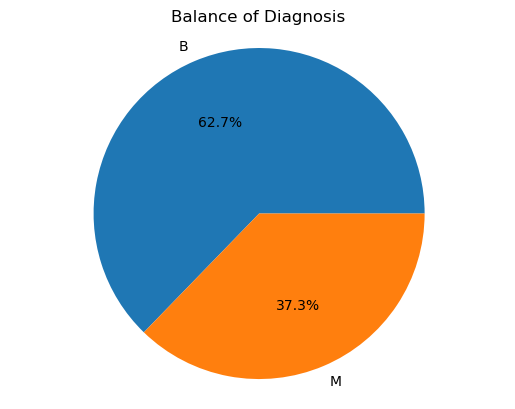

B    357
M    212
Name: diagnosis, dtype: int64

In [5]:
diagnosis_counts = data['diagnosis'].value_counts()

# Create a pie chart
plt.pie(diagnosis_counts.values, labels=diagnosis_counts.index, autopct='%1.1f%%')

# Customize the plot
plt.title('Balance of Diagnosis')
plt.axis('equal')
plt.show()

diagnosis_counts

## Label encoding
We exclude the 'id' column from our analysis as it serves as an identifier and does not contribute to the classification task.
And then, we employ label encoding to convert the target variable into binary form.

In [6]:
# Drop 'id' column
df = data.drop('id', axis=1)

# Label encode the 'diagnosis' variable to binary
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

# Display the updated data
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Train/Test split
before doing preprocessing, we perform stratified train/test split with 70% Train and 30% test

In [7]:
TEST_RATIO = 0.3  # split into 2 equally sized train and test sets

# Setup X and y
X = df.drop(['diagnosis'],axis=1) # drop the outcome 'diagnosis' 
y = df['diagnosis'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, stratify=y, random_state=305)
print("X_train.shape, y_train.shape:", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape:", X_test.shape, y_test.shape)

X_train.shape, y_train.shape: (398, 30) (398,)
X_test.shape, y_test.shape: (171, 30) (171,)


## Pipeline for preprocessing and training, tuning models
We construct a pipeline that encompasses several steps for preprocessing and training an SVM model. The pipeline comprises:
- Upsampling using borderlineSMOTE to address class imbalance.
- Normalization using StandardScaler to standardize the feature values.
- Dimension reduction using UMAP to reduce the dimensionality of the data.
- Utilizing the SVMRadial for classification task.

Next, we employ GridSearchCV to train the model using 10-fold cross-validation. This process involves tuning the model by exploring different options for the number of dimensions, the number of nearest neighbors used to determine the dimension, regularization levels (C), and kernel coefficient (gamma).

In [8]:
# Upsampling - Apply borderlineSMOTE to upsample the data
smote = BorderlineSMOTE(random_state = 305)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Resampled classes: \n", y_train_res.value_counts())

# Normalise
scaler = StandardScaler()

# Dimensional reduction using UMAP
umap = UMAP(random_state=305) 

# SVM with a radial basis function 
svm = SVC(random_state = 305, kernel='rbf') 

# Build params_grid 
params_grid_pipeline = {"umap__n_components": [5, 10, 15, 25],
                        "umap__n_neighbors": [3, 5, 10], 
                        "svm__C":[0.01, 0.1, 1],
                         "svm__gamma":[0.00001, 0.0001, 0.001]}
# Build Pipeline with the order: upsampling, normalisation, dimension reduction, SVMRadial.

pipeline = Pipeline([('sm', smote), ('scaler', scaler), ("umap", umap), ("svm",svm)])

grid_search = GridSearchCV(pipeline, param_grid=params_grid_pipeline, cv=10, verbose=10, scoring = 'roc_auc')

grid_search.fit(X_train_res, y_train_res)

Resampled classes: 
 0    250
1    250
Name: diagnosis, dtype: int64
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV 1/10; 1/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 1/10; 1/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=0.963 total time=   8.0s
[CV 2/10; 1/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 2/10; 1/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=0.986 total time=   1.6s
[CV 3/10; 1/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 3/10; 1/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=0.982 total time=   1.5s
[CV 4/10; 1/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 4/10; 1/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score

[CV 7/10; 4/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=3;, score=0.987 total time=   1.5s
[CV 8/10; 4/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=3
[CV 8/10; 4/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=3;, score=1.000 total time=   1.5s
[CV 9/10; 4/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=3
[CV 9/10; 4/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=3;, score=0.950 total time=   1.5s
[CV 10/10; 4/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=3
[CV 10/10; 4/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=3;, score=0.978 total time=   1.4s
[CV 1/10; 5/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5
[CV 1/10; 5/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5;, s

[CV 4/10; 8/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5;, score=0.997 total time=   1.8s
[CV 5/10; 8/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5
[CV 5/10; 8/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5;, score=0.942 total time=   1.8s
[CV 6/10; 8/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5
[CV 6/10; 8/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5;, score=0.990 total time=   1.7s
[CV 7/10; 8/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5
[CV 7/10; 8/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5;, score=0.949 total time=   1.8s
[CV 8/10; 8/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5
[CV 8/10; 8/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5;, sco

[CV 1/10; 12/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=0.989 total time=   2.6s
[CV 2/10; 12/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 2/10; 12/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=1.000 total time=   2.4s
[CV 3/10; 12/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 3/10; 12/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=0.979 total time=   2.6s
[CV 4/10; 12/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 4/10; 12/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=0.938 total time=   2.6s
[CV 5/10; 12/108] START svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 5/10; 12/108] END svm__C=0.01, svm__gamma=1e-05, umap__n_components=25, umap__n_

[CV 7/10; 15/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=10;, score=0.957 total time=   1.8s
[CV 8/10; 15/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=10
[CV 8/10; 15/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=10;, score=0.997 total time=   1.7s
[CV 9/10; 15/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=10
[CV 9/10; 15/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=10;, score=0.970 total time=   1.8s
[CV 10/10; 15/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=10
[CV 10/10; 15/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=10;, score=0.998 total time=   1.8s
[CV 1/10; 16/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3
[CV 1/10; 16/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=10, umap_

[CV 3/10; 19/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3;, score=0.984 total time=   1.6s
[CV 4/10; 19/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3
[CV 4/10; 19/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3;, score=0.978 total time=   1.5s
[CV 5/10; 19/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3
[CV 5/10; 19/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3;, score=0.920 total time=   1.6s
[CV 6/10; 19/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3
[CV 6/10; 19/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3;, score=0.928 total time=   1.6s
[CV 7/10; 19/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3
[CV 7/10; 19/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=15, umap__n

[CV 9/10; 22/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=3;, score=0.947 total time=   1.7s
[CV 10/10; 22/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=3
[CV 10/10; 22/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=3;, score=0.992 total time=   1.6s
[CV 1/10; 23/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5
[CV 1/10; 23/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5;, score=0.989 total time=   2.1s
[CV 2/10; 23/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5
[CV 2/10; 23/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5;, score=1.000 total time=   2.0s
[CV 3/10; 23/108] START svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5
[CV 3/10; 23/108] END svm__C=0.01, svm__gamma=0.0001, umap__n_components=25, umap_

[CV 5/10; 26/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5;, score=0.942 total time=   1.6s
[CV 6/10; 26/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5
[CV 6/10; 26/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5;, score=0.933 total time=   1.4s
[CV 7/10; 26/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5
[CV 7/10; 26/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5;, score=0.978 total time=   1.6s
[CV 8/10; 26/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5
[CV 8/10; 26/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5;, score=1.000 total time=   1.6s
[CV 9/10; 26/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5
[CV 9/10; 26/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=5;, sco

[CV 2/10; 30/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10;, score=1.000 total time=   2.0s
[CV 3/10; 30/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10
[CV 3/10; 30/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10;, score=0.923 total time=   2.0s
[CV 4/10; 30/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10
[CV 4/10; 30/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10;, score=0.958 total time=   1.9s
[CV 5/10; 30/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10
[CV 5/10; 30/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10;, score=0.962 total time=   2.1s
[CV 6/10; 30/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10
[CV 6/10; 30/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=10, umap__n_

[CV 8/10; 33/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=10;, score=0.997 total time=   2.2s
[CV 9/10; 33/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=10
[CV 9/10; 33/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=10;, score=0.978 total time=   2.1s
[CV 10/10; 33/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=10
[CV 10/10; 33/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=10;, score=0.998 total time=   2.2s
[CV 1/10; 34/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3
[CV 1/10; 34/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3;, score=0.978 total time=   1.7s
[CV 2/10; 34/108] START svm__C=0.01, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3
[CV 2/10; 34/108] END svm__C=0.01, svm__gamma=0.001, umap__n_components=25, umap__n_n

[CV 5/10; 37/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=0.941 total time=   1.4s
[CV 6/10; 37/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 6/10; 37/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=0.965 total time=   1.4s
[CV 7/10; 37/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 7/10; 37/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=0.989 total time=   1.3s
[CV 8/10; 37/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 8/10; 37/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=1.000 total time=   1.4s
[CV 9/10; 37/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3
[CV 9/10; 37/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=3;, score=0.952 

[CV 2/10; 41/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5;, score=1.000 total time=   1.7s
[CV 3/10; 41/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5
[CV 3/10; 41/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5;, score=0.930 total time=   1.5s
[CV 4/10; 41/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5
[CV 4/10; 41/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5;, score=0.992 total time=   1.7s
[CV 5/10; 41/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5
[CV 5/10; 41/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5;, score=0.950 total time=   1.7s
[CV 6/10; 41/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5
[CV 6/10; 41/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=5;, sco

[CV 9/10; 44/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5;, score=0.941 total time=   1.9s
[CV 10/10; 44/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5
[CV 10/10; 44/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=5;, score=0.971 total time=   1.7s
[CV 1/10; 45/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10
[CV 1/10; 45/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10;, score=0.976 total time=   2.2s
[CV 2/10; 45/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10
[CV 2/10; 45/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10;, score=1.000 total time=   2.2s
[CV 3/10; 45/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10
[CV 3/10; 45/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=

[CV 6/10; 48/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=0.963 total time=   2.6s
[CV 7/10; 48/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 7/10; 48/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=0.981 total time=   2.6s
[CV 8/10; 48/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 8/10; 48/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=0.997 total time=   2.4s
[CV 9/10; 48/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 9/10; 48/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10;, score=0.974 total time=   2.6s
[CV 10/10; 48/108] START svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=10
[CV 10/10; 48/108] END svm__C=0.1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbo

[CV 3/10; 52/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3;, score=0.984 total time=   1.5s
[CV 4/10; 52/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3
[CV 4/10; 52/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3;, score=0.986 total time=   1.4s
[CV 5/10; 52/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3
[CV 5/10; 52/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3;, score=0.957 total time=   1.5s
[CV 6/10; 52/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3
[CV 6/10; 52/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3;, score=0.946 total time=   1.5s
[CV 7/10; 52/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=3
[CV 7/10; 52/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbor

[CV 9/10; 55/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3;, score=0.941 total time=   1.8s
[CV 10/10; 55/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3
[CV 10/10; 55/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=3;, score=0.962 total time=   1.7s
[CV 1/10; 56/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5
[CV 1/10; 56/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5;, score=0.997 total time=   1.7s
[CV 2/10; 56/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5
[CV 2/10; 56/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5;, score=1.000 total time=   1.8s
[CV 3/10; 56/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5
[CV 3/10; 56/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighb

[CV 5/10; 59/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5;, score=0.934 total time=   2.6s
[CV 6/10; 59/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5
[CV 6/10; 59/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5;, score=0.982 total time=   2.3s
[CV 7/10; 59/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5
[CV 7/10; 59/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5;, score=0.938 total time=   2.0s
[CV 8/10; 59/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5
[CV 8/10; 59/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5;, score=1.000 total time=   2.2s
[CV 9/10; 59/108] START svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=5
[CV 9/10; 59/108] END svm__C=0.1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbor

[CV 2/10; 63/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10;, score=0.995 total time=   2.0s
[CV 3/10; 63/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10
[CV 3/10; 63/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10;, score=0.912 total time=   2.0s
[CV 4/10; 63/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10
[CV 4/10; 63/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10;, score=0.938 total time=   2.0s
[CV 5/10; 63/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10
[CV 5/10; 63/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10;, score=0.957 total time=   2.2s
[CV 6/10; 63/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10
[CV 6/10; 63/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=5, umap__n_neighbors=10;, sco

[CV 9/10; 66/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10;, score=0.968 total time=   2.2s
[CV 10/10; 66/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10
[CV 10/10; 66/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=10;, score=0.998 total time=   2.1s
[CV 1/10; 67/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=3
[CV 1/10; 67/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=3;, score=0.987 total time=   1.5s
[CV 2/10; 67/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=3
[CV 2/10; 67/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=3;, score=0.997 total time=   1.6s
[CV 3/10; 67/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=3
[CV 3/10; 67/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=3;

[CV 6/10; 70/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3;, score=0.978 total time=   2.0s
[CV 7/10; 70/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3
[CV 7/10; 70/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3;, score=0.982 total time=   2.0s
[CV 8/10; 70/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3
[CV 8/10; 70/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3;, score=1.000 total time=   1.8s
[CV 9/10; 70/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3
[CV 9/10; 70/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3;, score=0.941 total time=   1.9s
[CV 10/10; 70/108] START svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3
[CV 10/10; 70/108] END svm__C=0.1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=3;, s

[CV 3/10; 74/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5;, score=0.925 total time=   1.7s
[CV 4/10; 74/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5
[CV 4/10; 74/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5;, score=0.998 total time=   1.5s
[CV 5/10; 74/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5
[CV 5/10; 74/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5;, score=0.942 total time=   1.6s
[CV 6/10; 74/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5
[CV 6/10; 74/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5;, score=0.934 total time=   1.6s
[CV 7/10; 74/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5
[CV 7/10; 74/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=5, umap__n_neighbors=5;, score=0.978 total time=   1.7s

[CV 1/10; 78/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10;, score=0.990 total time=   2.0s
[CV 2/10; 78/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10
[CV 2/10; 78/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10;, score=1.000 total time=   2.1s
[CV 3/10; 78/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10
[CV 3/10; 78/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10;, score=0.925 total time=   2.2s
[CV 4/10; 78/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10
[CV 4/10; 78/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10;, score=0.960 total time=   2.1s
[CV 5/10; 78/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10
[CV 5/10; 78/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=10, umap__n_neighbors=10;, score=0.962 

[CV 8/10; 81/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10;, score=0.997 total time=   2.4s
[CV 9/10; 81/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10
[CV 9/10; 81/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10;, score=0.978 total time=   2.5s
[CV 10/10; 81/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10
[CV 10/10; 81/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=15, umap__n_neighbors=10;, score=0.998 total time=   2.6s
[CV 1/10; 82/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=3
[CV 1/10; 82/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=3;, score=0.978 total time=   2.1s
[CV 2/10; 82/108] START svm__C=1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=3
[CV 2/10; 82/108] END svm__C=1, svm__gamma=1e-05, umap__n_components=25, umap__n_neighbors=3;, score=1.000 to

[CV 5/10; 85/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3;, score=0.938 total time=   1.4s
[CV 6/10; 85/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3
[CV 6/10; 85/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3;, score=0.963 total time=   1.3s
[CV 7/10; 85/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3
[CV 7/10; 85/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3;, score=0.982 total time=   1.5s
[CV 8/10; 85/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3
[CV 8/10; 85/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3;, score=1.000 total time=   1.5s
[CV 9/10; 85/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3
[CV 9/10; 85/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=5, umap__n_neighbors=3;, score=0.954 total tim

[CV 2/10; 89/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5;, score=1.000 total time=   1.9s
[CV 3/10; 89/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5
[CV 3/10; 89/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5;, score=0.947 total time=   1.7s
[CV 4/10; 89/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5
[CV 4/10; 89/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5;, score=0.992 total time=   1.9s
[CV 5/10; 89/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5
[CV 5/10; 89/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5;, score=0.955 total time=   2.0s
[CV 6/10; 89/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5
[CV 6/10; 89/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=10, umap__n_neighbors=5;, score=0.976 

[CV 9/10; 92/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5;, score=0.952 total time=   1.9s
[CV 10/10; 92/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5
[CV 10/10; 92/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=5;, score=0.970 total time=   2.1s
[CV 1/10; 93/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=10
[CV 1/10; 93/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=10;, score=0.976 total time=   2.5s
[CV 2/10; 93/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=10
[CV 2/10; 93/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=10;, score=1.000 total time=   2.5s
[CV 3/10; 93/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=10
[CV 3/10; 93/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=15, umap__n_neighbors=10;, scor

[CV 6/10; 96/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10;, score=0.970 total time=   3.8s
[CV 7/10; 96/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10
[CV 7/10; 96/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10;, score=0.981 total time=   3.7s
[CV 8/10; 96/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10
[CV 8/10; 96/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10;, score=0.997 total time=   3.3s
[CV 9/10; 96/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10
[CV 9/10; 96/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10;, score=0.968 total time=   3.5s
[CV 10/10; 96/108] START svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10
[CV 10/10; 96/108] END svm__C=1, svm__gamma=0.0001, umap__n_components=25, umap__n_neighbors=10;, s

[CV 4/10; 100/108] END svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3;, score=0.984 total time=   2.1s
[CV 5/10; 100/108] START svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3
[CV 5/10; 100/108] END svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3;, score=0.984 total time=   2.0s
[CV 6/10; 100/108] START svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3
[CV 6/10; 100/108] END svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3;, score=0.960 total time=   2.0s
[CV 7/10; 100/108] START svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3
[CV 7/10; 100/108] END svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3;, score=0.958 total time=   1.8s
[CV 8/10; 100/108] START svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3
[CV 8/10; 100/108] END svm__C=1, svm__gamma=0.001, umap__n_components=10, umap__n_neighbors=3;, score=1.000 

[CV 1/10; 104/108] END svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5;, score=0.995 total time=   2.0s
[CV 2/10; 104/108] START svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5
[CV 2/10; 104/108] END svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5;, score=1.000 total time=   1.9s
[CV 3/10; 104/108] START svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5
[CV 3/10; 104/108] END svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5;, score=0.984 total time=   1.8s
[CV 4/10; 104/108] START svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5
[CV 4/10; 104/108] END svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5;, score=1.000 total time=   2.1s
[CV 5/10; 104/108] START svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5
[CV 5/10; 104/108] END svm__C=1, svm__gamma=0.001, umap__n_components=15, umap__n_neighbors=5;, score=0.950 

[CV 8/10; 107/108] END svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=5;, score=1.000 total time=   2.5s
[CV 9/10; 107/108] START svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=5
[CV 9/10; 107/108] END svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=5;, score=0.992 total time=   2.1s
[CV 10/10; 107/108] START svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=5
[CV 10/10; 107/108] END svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=5;, score=0.986 total time=   2.4s
[CV 1/10; 108/108] START svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=10
[CV 1/10; 108/108] END svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=10;, score=0.974 total time=   2.8s
[CV 2/10; 108/108] START svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=10
[CV 2/10; 108/108] END svm__C=1, svm__gamma=0.001, umap__n_components=25, umap__n_neighbors=10;, score=

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sm',
                                        BorderlineSMOTE(random_state=305)),
                                       ('scaler', StandardScaler()),
                                       ('umap', UMAP(random_state=305)),
                                       ('svm', SVC(random_state=305))]),
             param_grid={'svm__C': [0.01, 0.1, 1],
                         'svm__gamma': [1e-05, 0.0001, 0.001],
                         'umap__n_components': [5, 10, 15, 25],
                         'umap__n_neighbors': [3, 5, 10]},
             scoring='roc_auc', verbose=10)

## Best parameters so give the best AUROC result
The AUROC score is 0.9819 which is pretty good, and the model parameter values are
C = 1,  gamma = 0.001, n_components = 15, n_neighbors = 5

In [9]:
print(f'Best AUROC scoring: {grid_search.best_score_}')
print(f'Best hyperparameters: {grid_search.best_params_}')

Best AUROC scoring: 0.9819199999999999
Best hyperparameters: {'svm__C': 1, 'svm__gamma': 0.001, 'umap__n_components': 15, 'umap__n_neighbors': 5}


## Assessment
We examine how well model work on the unseen data

In [10]:
y_hat = grid_search.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       107
           1       0.91      0.95      0.93        64

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171



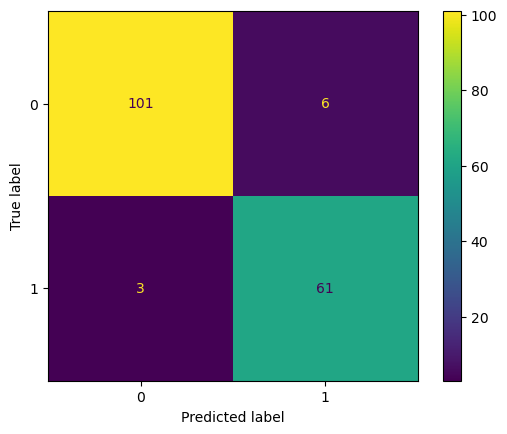

In [11]:
y_hat = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_hat, labels=grid_search.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
display.plot()
plt.show()

Overall, the model shows good performance with high precision, recall, and F1-score for both classes, as well as a high accuracy rate.

End of notebook.